In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import time
from numba import jit
import math

## Rao-Blackwellization of the Metropolis-Hasting algorithm in the general case

Use this cell to define the function target, the distribution target, and a way to sample from these densities, do not use scipy !  
Since we want to estimate $\mathbb{E}[h(x)]$, we also need to define both h and the true mean. The functions h will be used in the comparative analysis part of this notebook

#### Student with 3 degree of freedom as the target distribution with a cauchy proposal centered on the last accepted sample

In [5]:
@jit(nopython=True)
def f_target(x,nu=3): #Student density with 3 degree of freedom
    coeff = 2 / (np.sqrt(3 * np.pi**2))
    density = coeff * (1 + (x**2) / nu) ** (-(nu + 1) / 2)
    return density

@jit(nopython=True)
def g_proposal(x,x0,scale): #Cauchy density
    return 1 / (np.pi * (1/scale) * (1 + ((x - x0) / (1/scale))**2))

@jit(nopython=True)
def f_sampling(): #Function to sample from f 
    return np.random.standard_t(3)

@jit(nopython=True)
def g_sampling(x0,scale): #function to sample from g
    return x0 + np.random.standard_cauchy() * (1/scale)

#To compute the mean of f 
@jit(nopython=True)
def h1(x):
    return x
true_mean1 = 0 #mean of f

#To compute tail probability of f
y = stats.t(3).ppf(0.95) #f.ppf(0.95) gives us y so that P(X>y)=0.05 where X has f for density
@jit(nopython=True)
def h2(x):
    return np.where(x>y,1,0) 
true_mean2 = 0.05 

xx = np.linspace(-6, 6, 250) #for the graph next cell

#### Normal target with mu=3,sigma=1 with a Normal proposal centered on the last accepted sample

#### Optimized version of the Metropolis-Hasting Algorithm :
This version used memory-preallocation and avoid recalculating the same densities. It is about 2 times faster than the previous one.

In [8]:
@jit(nopython=True)
def metropolis_hastings(numb_runs, num_samples, sigma):
    proposed_samples = np.zeros((numb_runs, num_samples + 1))
    accepted_samples = np.zeros((numb_runs, num_samples + 1))
    random_uniforms = np.random.rand(numb_runs, num_samples + 1)
    compteur_accept = 0
    

    for j in range(numb_runs):
        current_sample = f_sampling()  # Starting sample from the target
        accepted_samples[j, 0] = current_sample
        proposed_samples[j, 0] = current_sample
        f_current = f_target(current_sample)

        for i in range(1, num_samples + 1):
            proposal = g_sampling(current_sample, sigma) 
            g_current_to_proposal = g_proposal(current_sample, proposal, sigma)
            g_proposal_to_current = g_proposal(proposal, current_sample, sigma)
            

            f_proposed = f_target(proposal)

            # Calculate the acceptance ratio
            acceptance_ratio = (f_proposed / f_current) * (g_current_to_proposal / g_proposal_to_current)
            acceptance_ratio = min(1, acceptance_ratio)

            # Accept or reject the proposal
            if random_uniforms[j, i - 1] < acceptance_ratio:
                current_sample = proposal
                f_current = f_proposed
                compteur_accept += 1

            proposed_samples[j, i] = proposal
            accepted_samples[j, i] = current_sample
    acceptance_rate = 100 * compteur_accept / (numb_runs * num_samples)
    return accepted_samples, proposed_samples,acceptance_rate

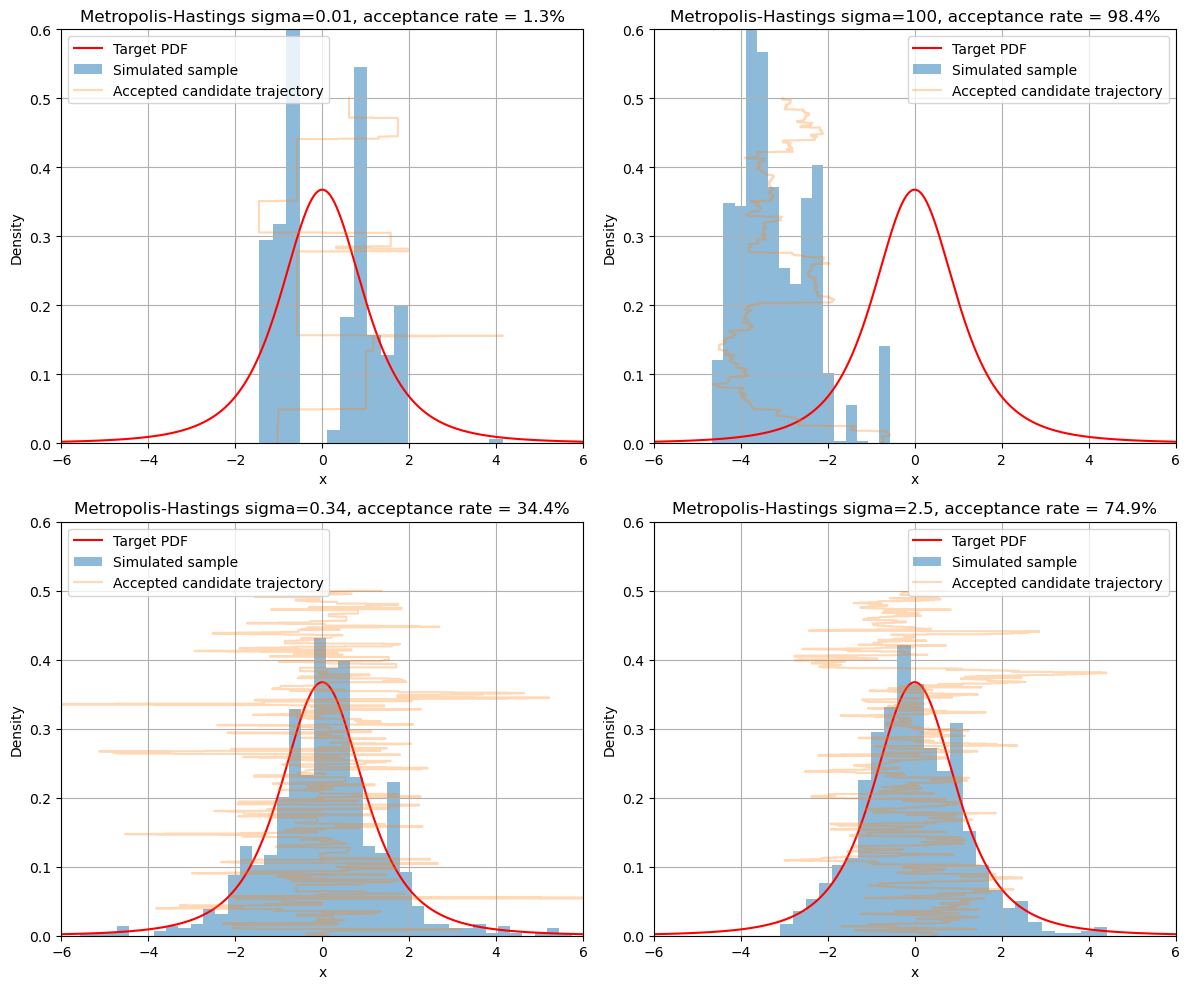

In [49]:
numb_runs = 1
num_samples = 1000
sigma_values = [0.01, 100, 0.34, 2.5]
xx = np.linspace(-6, 6, 1000)  # Range of x values for plotting the target PDF

# Create a 2x2 plot
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()  # Flatten the 2D array of axes into a 1D array for easier indexing

for idx, sigma in enumerate(sigma_values):
    accepted_samples, proposed_samples, acceptance_rate = metropolis_hastings(numb_runs, num_samples, sigma)
    
    # Compute the target PDF for plotting
    pdf_values = np.array([f_target(x) for x in xx])

    # Plot on the corresponding subplot
    ax = axs[idx]
    ax.plot(xx, pdf_values, label="Target PDF", color="red")
    ax.hist(accepted_samples[0, :], bins='auto', density=True, alpha=0.5, label="Simulated sample")
    steps = np.linspace(0, 0.5, num_samples + 1)
    ax.step(accepted_samples[0, :], steps[:len(accepted_samples[0, :])], alpha=0.3, where='mid', label="Accepted candidate trajectory")
    ax.set_title(f"Metropolis-Hastings sigma={sigma}, acceptance rate = {acceptance_rate}%")
    ax.set_xlabel("x")
    ax.set_ylabel("Density")
    ax.legend()
    ax.set_xlim(-6,6)
    ax.set_ylim(0,0.6)
    ax.grid()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


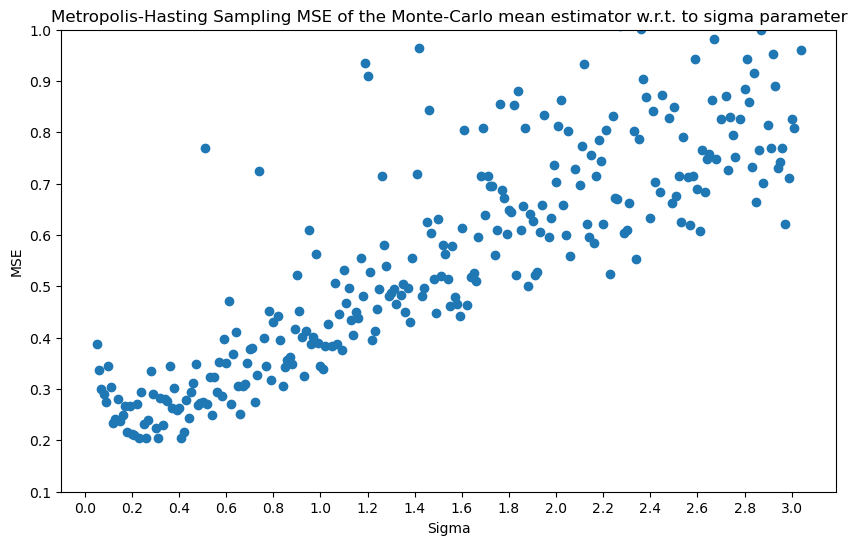

In [10]:
number_of_samples = 5000
sample_size = 100

mse_list = []

def calc_mse(est_array):
    return np.mean((np.array(est_array)-0)**2)

sigmas = np.arange(0.05,3.05,0.01)
for sigma in sigmas:
    accept_matrix,_,_ = metropolis_hastings(number_of_samples, sample_size, sigma)
    mc_est = []
    for j in range(number_of_samples):
        mc_est.append(np.mean(accept_matrix[j,:]))
    mse = calc_mse(mc_est)
    mse_list.append(mse)


plt.figure(figsize=(10, 6))    
plt.title("Metropolis-Hasting Sampling MSE of the Monte-Carlo mean estimator w.r.t. to sigma parameter")
plt.xlabel("Sigma")
plt.ylabel("MSE")
plt.scatter(sigmas,mse_list)
plt.ylim(0.1,1)
plt.xticks(np.arange(0,3.1,0.2))
plt.show()

### Implementation of the Rao-Blackwellized Monte Carlo, Importance-Sampling and Rao-Blackwellized Imp. Sampl. estimators :
This implementations takes advantage of numpy vectorization, memory pre-allocation (computing G,F,Rho in advance to avoid redundant calculations), and use JIT to maximize the computation speed. 

In [12]:
@jit(nopython=True)
def compute_G(Y,sigma):
    n = len(Y)
    G = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            G[i, j] = g_proposal(Y[i], Y[j], sigma) 
    return G

@jit(nopython=True)
def compute_F(Y):
    return f_target(Y)


@jit(nopython=True)
def compute_rho(Y,F,G):
    n = len(Y)
    rho = np.ones((n,n))
    for i in range(n):
        for j in range(n):
            rho[i,j]= np.minimum(1, (F[j]/G[j,i])  /  (F[i]/G[i,j]))
    return rho


@jit(nopython=True)
def compute_rho_hat_star(Y, rho, G):
    n = len(Y)-1
    rho_hat_star = np.zeros((n, n))
    for i in range(n-1):
        for j in range(i + 1, n):
            rho_hat_star[i, j] = rho[i,j]*G[j+1,j]
    return rho_hat_star

@jit(nopython=True)
def compute_rho_star(Y, rho, G):
    n = len(Y)-1
    rho_star = np.zeros((n, n))
    for i in range(n-1):
        for j in range(i + 1, n):
            rho_star[i, j] = (1-rho[i,j])*G[j+1,i]
    return rho_star

@jit(nopython=True)
def compute_zeta(Y, rho_star):
    n = len(Y)-1
    zeta = np.eye(n)
    for i in range(n-1):
        for j in range(i + 1, n):
            zeta[i, j] = zeta[i, j-1]*rho_star[i,j]
    return zeta


@jit(nopython=True)
def compute_deltas(Y, zeta, rho_hat_star,rho):
    n = len(Y)-1
    deltas = np.zeros(n+1)
    deltas[0] = 1
    for j in range(1,n):
        sum_term = 0
        for t in range(0,j):
            sum_term += deltas[t] * zeta[t, j - 1] * rho_hat_star[t, j]
        deltas[j] = sum_term
    for t in range(n):
        deltas[n]+=deltas[t]*zeta[t,n-1]*rho[t,n]
    return deltas


@jit(nopython=True)
def compute_omega(Y,rho_hat_star, rho_star):
    n = len(Y)
    omegas = np.zeros((n, n))
    for i in range(n):
        omegas[n-1,i]=1
    for i in range(n - 2, 0, -1):
        for j in range(i):
            omegas[i, j] = rho_hat_star[j,i] * omegas[i + 1, i] + rho_star[j, i] * omegas[i + 1, j]
    return omegas


@jit(nopython=True)
def compute_phi(i, Y, rho, zeta, deltas, omegas):
    n = len(Y) - 1
    if i == n:
        return deltas[n]
    else:
        sum_term = 0
        for j in range(i, n):
            sum_term += zeta[i, j] * omegas[j+1, i]
        sum_term += zeta[i, n - 1] * (1 - rho[i, n])  
        return deltas[i] * sum_term

    
@jit(nopython=True)
def rao_blackwell_estimator(Y,sigma,h):

    #Pre-computing 
    n = len(Y) - 1
    F = compute_F(Y)
    G = compute_G(Y,sigma)
    rho = compute_rho(Y, F, G)
    rho_hat_star = compute_rho_hat_star(Y, rho, G)
    rho_star = compute_rho_star(Y, rho, G)
    zeta = compute_zeta(Y, rho_star)
    deltas = compute_deltas(Y, zeta, rho_hat_star, rho)
    omegas = compute_omega(Y, rho_hat_star, rho_star)
    
    #Denominator
    den=0
    for i in range(n):
        den += deltas[i] * zeta[i, n-1]
        
    #Numerator
    num=0
    for i in range(n + 1):
        phi_i = compute_phi(i, Y, rho, zeta, deltas, omegas)
        num += phi_i * h(Y[i])

    return (num / den) / (n+1)

@jit(nopython=True)
def rao_blackwell_importance_sampling_estimator(Y,sigma,h):

    #Pre-computing
    n = len(Y)-1
    F = compute_F(Y)
    G = compute_G(Y,sigma)
    rho = compute_rho(Y, F, G)
    rho_hat_star = compute_rho_hat_star(Y, rho, G)
    rho_star = compute_rho_star(Y, rho, G)
    zeta = compute_zeta(Y, rho_star)
    deltas = compute_deltas(Y, zeta, rho_hat_star, rho)
    omegas = compute_omega(Y, rho_hat_star, rho_star)
    
    #Denominator
    den = 0
    for i in range(n):
        den+= deltas[i]*zeta[i,n-1]

    #Numerator
    num = 0
    for i in range(2,n+1):
        for j in range(0,i):
            num+= F[i]*deltas[j]*zeta[j,i-2]*omegas[i,j]*h(Y[i])
            
    return (h(Y[0]) + h(Y[1])*F[1]/G[1,0]+(num/den)) / (n+1)


@jit(nopython=True)
def importance_sampling_estimator(accept,proposal,sigma,h):

    n = len(proposal)-1
    est = 0
    for j in range(1,n+1):
        est+= ( f_target(proposal[j])/g_proposal(proposal[j], accept[j-1], sigma) )*h(proposal[j])/(n+1)
    return est

def monte_carlo_estimator(accept,h):
    return np.sum(np.array(h(accept)))/(len(accept))

In [13]:
#Parameters
number_of_samples = 5000
sample_size = 100
sigma = 0.34
h = h2
true_mean = true_mean2

# Collect the samples
accept_samples, proposal_samples,_ = metropolis_hastings(number_of_samples,sample_size,sigma)


#Main computation
res_RB = []
res_MC = []
res_IS = []
res_IS_RB = []

for j,sample in enumerate(proposal_samples):

    # Classic MC estimator 
    res_MC.append(monte_carlo_estimator(accept_samples[j],h))

    # Rao-Blackwellized MH estimator 
    res_RB.append(rao_blackwell_estimator(sample,sigma,h))
    
    # Import. Sampl. estimator 
    res_IS.append(importance_sampling_estimator(accept_samples[j],sample,sigma,h))
    
    # Rao-Blackwellized IS estimator 
    res_IS_RB.append(rao_blackwell_importance_sampling_estimator(sample,sigma,h))



# Display the means
print(f"Target mean: {true_mean}")
print(f"Classic MC empirical average mean: {np.mean(res_MC):.5f}")
print(f"Rao-Blackwell empirical average mean: {np.mean(res_RB):.5f}")
print(f"Importance Sampling empirical average mean: {np.mean(res_IS):.5f}")
print(f"Rao-Blackwell Imp. Samp. average mean: {np.mean(res_IS_RB):.5f}")

# Compute and display the MSEs
classic_mc_mse = np.mean((np.array(res_MC) - true_mean) ** 2)
rao_blackwell_mse = np.mean((np.array(res_RB) - true_mean) ** 2)
importance_sampling_mse = np.mean((np.array(res_IS) - true_mean) ** 2)
RB_importance_sampling_mse = np.mean((np.array(res_IS_RB) - true_mean) ** 2)

print(f"\nClassic MC MSE: {classic_mc_mse:.5f}")
print(f"Rao-Blackwell MSE: {rao_blackwell_mse:.5f}")
print(f"Importance Sampling MSE: {importance_sampling_mse:.5f}")
print(f"Rao-Blackwell Imp. Samp. MSE: {RB_importance_sampling_mse:.5f}")

# Compute MSE decrease percentages
mse_decrease_rb = classic_mc_mse - rao_blackwell_mse
percent_decrease_rb = (mse_decrease_rb / classic_mc_mse) * 100

mse_decrease_is = classic_mc_mse - importance_sampling_mse
percent_decrease_is = (mse_decrease_is / classic_mc_mse) * 100

mse_decrease_rb_is = classic_mc_mse - RB_importance_sampling_mse
percent_decrease_rb_is = (mse_decrease_rb_is / classic_mc_mse) * 100

print("")
print(f"Percentage decrease in MSE (Rao-Blackwell vs Classic MC): {percent_decrease_rb:.2f}%")
print(f"Percentage decrease in MSE (Importance Sampling vs Classic MC): {percent_decrease_is:.2f}%")
print(f"Percentage decrease in MSE (Rao-Blackwell Imp. Samp. vs Classic MC): {percent_decrease_rb_is:.2f}%")

Target mean: 0.05
Classic MC empirical average mean: 0.04828
Rao-Blackwell empirical average mean: 0.04900
Importance Sampling empirical average mean: 0.04921
Rao-Blackwell Imp. Samp. average mean: 0.04966

Classic MC MSE: 0.00305
Rao-Blackwell MSE: 0.00232
Importance Sampling MSE: 0.00020
Rao-Blackwell Imp. Samp. MSE: 0.00019

Percentage decrease in MSE (Rao-Blackwell vs Classic MC): 23.80%
Percentage decrease in MSE (Importance Sampling vs Classic MC): 93.53%
Percentage decrease in MSE (Rao-Blackwell Imp. Samp. vs Classic MC): 93.78%


## Comparative Analysis of Estimation Techniques: Classic Monte Carlo, Rao-Blackwell Metropolis Hasting, Importance Sampling, and Rao Blackwell Imp. Sampl. :

In [15]:
samples_sizes = [5,10,25,50,100,150]
number_of_samples = 50000
sigmas = [0.34,2.5]

Matrix_res_33_h1 = np.zeros((len(samples_sizes),11))
Matrix_res_75_h1 = np.zeros((len(samples_sizes),11))
Matrix_res_33_h2 = np.zeros((len(samples_sizes),11))
Matrix_res_75_h2 = np.zeros((len(samples_sizes),11))


for h,true_mean in zip([h1,h2],[true_mean1,true_mean2]):
    for c,sigma in enumerate(sigmas):

        if true_mean == true_mean1:
            Matrix_res = Matrix_res_33_h1 if sigma==0.34 else Matrix_res_75_h1
        else : 
            Matrix_res = Matrix_res_33_h2 if sigma==0.34 else Matrix_res_75_h2
            
        for i,s in enumerate(samples_sizes) : 
            res_RB = []
            res_MC = []
            res_IS = []
            res_IS_RB = []
            
            for j in range (number_of_samples):
        
                accept,propos,_ = metropolis_hastings(1,s,sigma)
                accept=accept[0,:]
                propos=propos[0,:]
                Y = propos
           
                # Classic MC estimator 
                res_MC.append(monte_carlo_estimator(accept,h))
                # Rao-Blackwellized estimator 
                res_RB.append(rao_blackwell_estimator(Y,sigma,h))
    
                # Importance Sampling estimator 
                res_IS.append(importance_sampling_estimator(accept,propos,sigma,h))
                
                # Rao-Blackwellized Import. Sampl. estimator 
                res_IS_RB.append(rao_blackwell_importance_sampling_estimator(Y,sigma,h))
                
            progress_message = f"Progress: {(c+1)*(i+1)}/{2*len(samples_sizes)}"
            print(progress_message.ljust(50), end='\r')
    
            
            
            Matrix_res[i,0]=np.mean(res_MC)
            Matrix_res[i,1]=np.mean(res_RB)
            Matrix_res[i,2]=np.mean(res_IS)
            Matrix_res[i,3]=np.mean(res_IS_RB)
            
        
            classic_mc_mse = np.mean((np.array(res_MC) - true_mean) ** 2)
            rao_blackwell_mse = np.mean((np.array(res_RB) - true_mean) ** 2)
            importance_sampling_mse = np.mean((np.array(res_IS) - true_mean) ** 2)
            rb_importance_sampling_mse = np.mean((np.array(res_IS_RB) - true_mean) ** 2)
        
            Matrix_res[i,4]=classic_mc_mse
            Matrix_res[i,5]=rao_blackwell_mse
            Matrix_res[i,6]=importance_sampling_mse
            Matrix_res[i,7]=rb_importance_sampling_mse
            
            
            # Compute MSE decrease percentages
            mse_decrease_rb = classic_mc_mse - rao_blackwell_mse
            percent_decrease_rb = (mse_decrease_rb / classic_mc_mse) * 100
            
            mse_decrease_is = classic_mc_mse - importance_sampling_mse
            percent_decrease_is = (mse_decrease_is / classic_mc_mse) * 100
    
            mse_decrease_is_rb = classic_mc_mse - rb_importance_sampling_mse
            percent_decrease_is_rb = (mse_decrease_is_rb / classic_mc_mse) * 100
            
            Matrix_res[i,8]=percent_decrease_rb
            Matrix_res[i,9]=percent_decrease_is
            Matrix_res[i,10]=percent_decrease_is_rb

#### Estimation of the mean of the target distribution with acceptance rate 33% over 50000 runs:

In [17]:
results = [
    'MC Metrop.',
    'RB Metrop.',
    'Imp. sampl.',
    'RB import. sampl.',
    'MSE Metrop.',
    'MSE decrease RB over MC (%)',
    'MSE decrease IS over MC (%)',
    'MSE decrease RB-IS over MC (%)']
indice = np.array([0,1,2,3,4,8,9,10])

df_results = pd.DataFrame(Matrix_res_33_h1[:,indice], index=samples_sizes, columns = results)
df_results.index.name = 'Sample size'

df_results.round(5)

,MC Metrop.,RB Metrop.,Imp. sampl.,RB import. sampl.,MSE Metrop.,MSE decrease RB over MC (%),MSE decrease IS over MC (%),MSE decrease RB-IS over MC (%)
Sample size,,,,,,,,
5,0.00954,0.00977,-0.00089,0.00091,1.91035,10.70765,84.43031,80.87181
10,-0.00112,0.00214,0.00210,0.00237,1.56540,10.01938,89.03683,87.79027
25,0.00355,0.00506,0.00110,0.00110,0.92394,8.65595,91.58833,91.61662
50,-0.00017,0.00066,-0.00110,-0.00095,0.59362,7.50044,93.06598,93.29389
100,-0.00168,-0.00219,-0.00008,-0.00018,0.23947,10.06434,91.27679,91.73879
150,-0.00226,-0.00182,-0.00029,-0.00036,0.24185,5.92390,94.18668,94.48153


#### Estimation of the mean of the target distribution with acceptance rate 75% over 50000 runs:

In [19]:
df_results = pd.DataFrame(Matrix_res_75_h1[:,indice], index=samples_sizes, columns = results)
df_results.index.name = 'Sample size'

df_results.round(5)

,MC Metrop.,RB Metrop.,Imp. sampl.,RB import. sampl.,MSE Metrop.,MSE decrease RB over MC (%),MSE decrease IS over MC (%),MSE decrease RB-IS over MC (%)
Sample size,,,,,,,,
5,-0.00110,-0.00046,0.00070,-0.00142,2.50590,0.58719,66.75962,52.62270
10,-0.00490,-0.00500,-0.00437,-0.00252,2.28651,0.33892,75.44463,71.73178
25,0.00803,0.00768,-0.00382,-0.00350,1.71327,0.18320,86.66218,84.49874
50,-0.00185,-0.00204,0.00296,0.00166,1.64662,0.03028,92.03038,90.26549
100,0.00268,0.00278,-0.00213,-0.00222,0.92943,0.08436,92.69137,91.51792
150,0.00225,0.00230,0.00126,0.00096,0.57526,0.09720,92.67892,90.79566


#### Estimation of the tail of the target distribution choosen to be 0.05 with acceptance rate 33% over 50000 runs:

In [21]:
df_results = pd.DataFrame(Matrix_res_33_h2[:,indice], index=samples_sizes, columns = results)
df_results.index.name = 'Sample size'

df_results.round(5)

,MC Metrop.,RB Metrop.,Imp. sampl.,RB import. sampl.,MSE Metrop.,MSE decrease RB over MC (%),MSE decrease IS over MC (%),MSE decrease RB-IS over MC (%)
Sample size,,,,,,,,
5,0.04981,0.04986,0.04200,0.05008,0.02801,21.62705,90.27483,86.16187
10,0.04975,0.05002,0.04551,0.05005,0.02012,23.66670,91.93486,90.15815
25,0.04992,0.04996,0.04795,0.04987,0.01089,24.29786,93.18395,92.79064
50,0.05035,0.05017,0.04908,0.05005,0.00604,24.62242,93.55598,93.53553
100,0.05028,0.05037,0.04952,0.04997,0.00327,23.39827,94.14791,94.24520
150,0.05007,0.05016,0.04972,0.05004,0.00213,23.37578,94.05050,94.19617


#### Estimation of the tail of the target distribution choosen to be 0.05 with acceptance rate 75% over 50000 runs:

In [23]:
df_results = pd.DataFrame(Matrix_res_75_h2[:,indice], index=samples_sizes, columns = results)
df_results.index.name = 'Sample size'

df_results.round(4)

,MC Metrop.,RB Metrop.,Imp. sampl.,RB import. sampl.,MSE Metrop.,MSE decrease RB over MC (%),MSE decrease IS over MC (%),MSE decrease RB-IS over MC (%)
Sample size,,,,,,,,
5,0.0498,0.0499,0.0408,0.0490,0.0354,1.9897,66.5548,57.3821
10,0.0504,0.0504,0.0451,0.0495,0.0304,1.5483,76.2793,61.5875
25,0.0505,0.0504,0.0480,0.0497,0.0213,1.0487,84.6648,78.0922
50,0.0495,0.0496,0.0493,0.0501,0.0138,0.7202,87.7245,81.9242
100,0.0492,0.0492,0.0497,0.0502,0.0080,0.5751,88.9158,83.0296
150,0.0501,0.0501,0.0497,0.0500,0.0059,0.5750,89.4799,84.3713


#### How many more sample do we have to generate using MH to achieve the same MSE as the Rao-Blackwell estimator with samples size = 100 ?

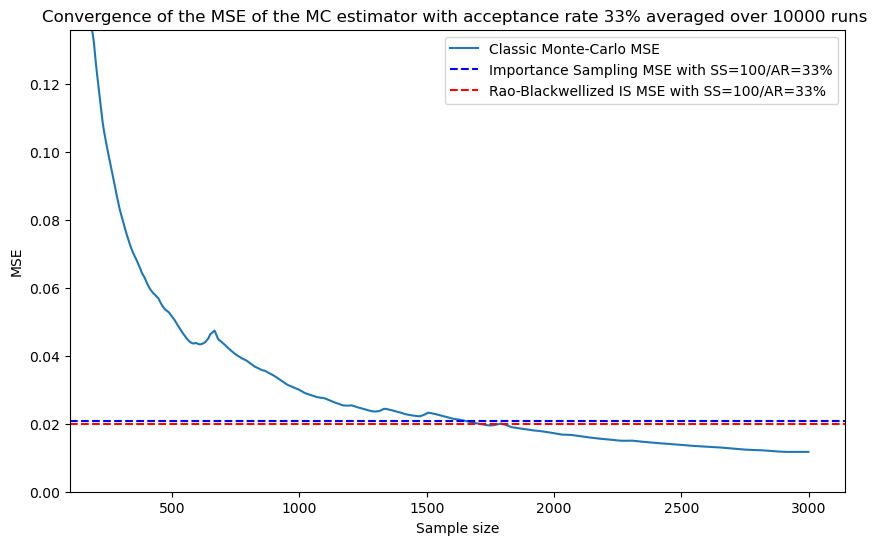

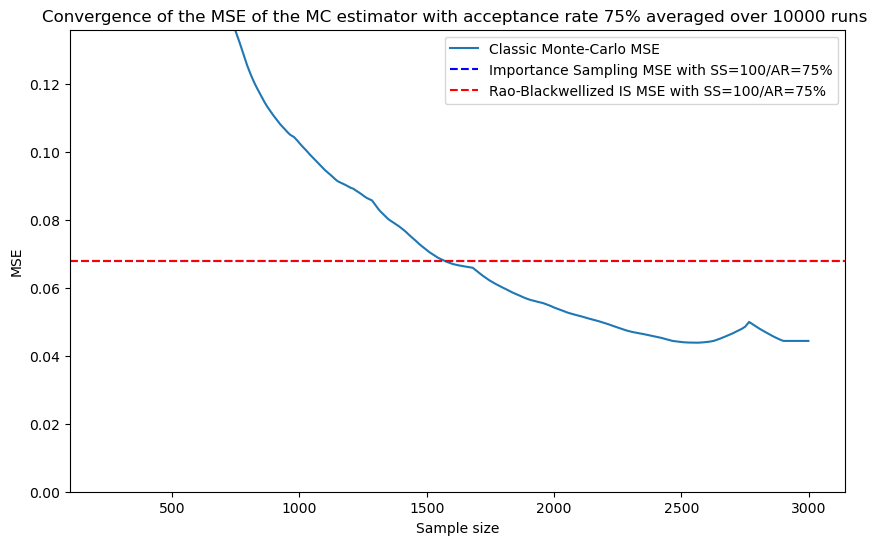

In [25]:
# Parameters
MSE_values_is = [Matrix_res_33_h1[4,6], Matrix_res_75_h1[4,6]]
MSE_values_is_rb = [Matrix_res_33_h1[4,7], Matrix_res_75_h1[4,6]]
h = h1
true_mean = true_mean1
number_of_samples = 10000
sigmas = [0.34,2.5]
AR = ['33%','75%']

for k,sigma in enumerate(sigmas):
    
    tt = np.arange(100, 3000, 1)
    mse_mh = np.zeros(len(tt))
    
    for j in range(number_of_samples):
        
        accept, _, _ = metropolis_hastings(1,len(tt), sigma) 
        accept = accept[0,:]
        # For each t in tt, calculate MSE from the start of the chain up to t
        for i,t in enumerate(tt):
            subset_accept = accept[:t]
            MC_estimate = ((monte_carlo_estimator(subset_accept,h) - true_mean) ** 2)/number_of_samples
            mse_mh[i]+= MC_estimate
    
        # Progress indicator
        progress = 100 * (j + 1) / number_of_samples
        print(f"Progress: {progress:.2f}%".ljust(50), end='\r')
    
    
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(tt, mse_mh, label='Classic Monte-Carlo MSE')
    plt.axhline(y=MSE_values_is[k], color='b', linestyle='--', label=f'Importance Sampling MSE with SS=100/AR={AR[k]}')
    plt.axhline(y=MSE_values_is_rb[k], color='r', linestyle='--', label=f'Rao-Blackwellized IS MSE with SS=100/AR={AR[k]}')
    plt.legend()
    plt.ylim(0, 2 * MSE_values_is[1])
    plt.xlim(100)
    plt.xlabel('Sample size')
    plt.ylabel('MSE')
    plt.title(f"Convergence of the MSE of the MC estimator with acceptance rate {AR[k]} averaged over {number_of_samples} runs ")
    plt.show()


#### Computation time comparison for the four estimators

In [45]:
# Parameters
size = [1400,1400,1600,1600]
number_of_samples = 5000  # Number of runs for the average computation time and MSE
sigmas = [0.34,2.5]
h = h1
true_mean = true_mean1 # True mean for MSE calculation

results = []

compteur = 1
# Classic Monte Carlo MSE and time computation 
for k,s in enumerate(size):
    
    sigma = 0.34 if (k==0 or k==1) else 2.5
    
    
    start_time = time.time()
    mse_classic_mc = 0
        
    for i in range(number_of_samples):
        accept, _,_ = metropolis_hastings(1,s,sigma)
        temp = np.mean(accept)
        mse_classic_mc += (temp - true_mean) ** 2  # Accumulate squared error
        
    
    mse_classic_mc /= number_of_samples
    end_time = time.time()
    loop_time = (end_time - start_time) / number_of_samples  

    results.append({
        "Estimator": "Classic MC",
        "Size": s,
        "Sigma": sigma,
        "Time (s)": loop_time,
        "MSE": mse_classic_mc
    })
    compteur+=1

#Importance Sampling and Rao-BlackWell Imp. Sampl. MSE and times computation
for k,sigma in enumerate(sigmas):
    
    start_time = time.time()
    samples_proposal = []
    samples_accept, samples_proposal,_ = metropolis_hastings(number_of_samples,100,sigma)
    
    res = []
    for j in range(number_of_samples):
    
        res.append(rao_blackwell_importance_sampling_estimator(samples_proposal[j,:],sigma,h))
        
        

    mse_importance_sampling = np.mean((np.array(res) - true_mean) ** 2)
    end_time = time.time()
    loop_time = (end_time - start_time) / number_of_samples

    results.append({
        "Estimator": "RB Importance Sampling",
        "Size": 100,
        "Sigma": sigma,
        "Time (s)": loop_time,
        "MSE": mse_importance_sampling
        })
    compteur+=1
    
    start_time = time.time()
    samples_accept = []
    samples_proposal = []
    
    samples_accept, samples_proposal,_ = metropolis_hastings(number_of_samples,100,sigma)
       
    
    res = []
    for j in range(number_of_samples):
    
        res.append(importance_sampling_estimator(samples_accept[j,:],samples_proposal[j,:],sigma,h))
    
        

    mse_importance_sampling = np.mean((np.array(res) - true_mean) ** 2)
    end_time = time.time()
    loop_time = (end_time - start_time) / number_of_samples

    results.append({
        "Estimator": "Importance Sampling",
        "Size": 100,
        "Sigma": sigma,
        "Time (s)": loop_time,
        "MSE": mse_importance_sampling
        })
    compteur+=1


print("Results :")
results_df = pd.DataFrame(results)
df_rate_33 = results_df[results_df["Sigma"] == 0.34].round(5)
df_rate_75 = results_df[results_df["Sigma"] == 2.5].round(5)

print("Results for Acceptance rate 33%")
print(df_rate_33)
print("\nResults for Acceptance rate 75%")
print(df_rate_75)
#Those value should be re-organized properly in the report 

Results :
Results for Acceptance rate 33%
                Estimator  Size  Sigma  Time (s)      MSE
0              Classic MC  1400   0.34   0.00011  0.02147
1              Classic MC  1400   0.34   0.00011  0.02736
4  RB Importance Sampling   100   0.34   0.00008  0.02029
5     Importance Sampling   100   0.34   0.00001  0.02065

Results for Acceptance rate 75%
                Estimator  Size  Sigma  Time (s)      MSE
2              Classic MC  1600    2.5   0.00012  0.06861
3              Classic MC  1600    2.5   0.00012  0.90233
6  RB Importance Sampling   100    2.5   0.00008  0.07854
7     Importance Sampling   100    2.5   0.00001  0.06668
